In [87]:
import numpy as np
import matplotlib.pyplot as plt


class Map:
    
    def __init__(self, pos: tuple, shape: tuple, scale: float) -> None:
        self.pos = np.array(pos, dtype=np.int16)
        self.array = np.zeros(shape, dtype=np.uint16)
        self.scale = scale
    
    
    def __contains__(self, value) -> bool:
        i = np.array(value)
        low, high = self.limits()
        return all(i >= low) and all(i < high)
    
    
    def __getitem__(self, key) -> int | np.ndarray:
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        return self.array[*index]
    
    
    def __setitem__(self, key, value: int):
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        self.array[*index] = value
    
    
    def limits(self) -> tuple[np.ndarray, np.ndarray]:
        return self.pos, self.pos + self.array.shape
    
    
    def update(self, other):
        if self.scale != other.scale:
            raise ValueError(f'Масштаб карт при сложении отличается: {self.scale} и {other.scale}')
        low1, high1 = self.limits()
        low2, high2 = other.limits()
        new_pos = np.min(np.vstack((low1, low2)), axis=0)
        new_high = np.max(np.vstack((high1, high2)), axis=0)
        new_array = np.zeros(new_high-new_pos, dtype=np.uint16)
        new_array[*[slice(l, h) for l, h in zip(low1-new_pos, low1-new_pos + np.array(self.array.shape))]] += self.array
        new_array[*[slice(l, h) for l, h in zip(low2-new_pos, low2-new_pos + np.array(other.array.shape))]] += other.array
        self.pos = new_pos
        self.array = new_array
        

    def show(self):
        x_min, y_max, x_max, y_min = np.concatenate(self.limits())*self.scale
        plt.imshow(self.array, cmap='gray_r', extent=[y_max, y_min, x_max, x_min])
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.grid(which='both')


def new_measurement(coords: np.ndarray, data: np.ndarray, scale: float) -> Map:
    x, y, rot = coords
    angle = np.linspace(-2*np.pi/3, 2*np.pi/3, len(data))
    data[data == 5.6] = np.nan
    data[data < 0.3] = np.nan
    xs = np.array([x + data * np.cos(rot-angle)]).transpose()
    ys = np.array([y + data * np.sin(rot-angle)]).transpose()
    points = np.hstack((xs, ys))
    points = points[~np.isnan(points).any(axis=1)]
    decomposed = (points // np.array([scale, scale])).astype(np.int16)
    decoposed_coords, counts = np.unique(decomposed, axis=0, return_counts=True)
    x_min, y_min, x_max, y_max = *decoposed_coords.min(axis=0), *decoposed_coords.max(axis=0)
    size = np.array([x_max - x_min + 1, y_max - y_min + 1])
    TOPLEFT = np.array([x_min, y_min])
    cell_map = np.zeros(size, dtype=np.uint16)
    for coord, n in zip(decoposed_coords, counts):
        cell_map[*(coord-TOPLEFT)] = n
    cell_map = cell_map.transpose()
    obj = Map(tuple(reversed(TOPLEFT)), cell_map.shape, scale)
    obj.array = cell_map
    return obj

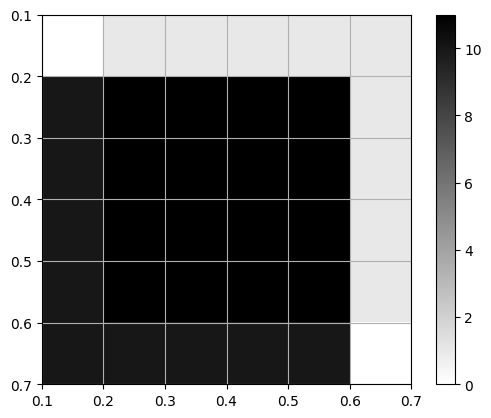

In [88]:
a = Map((1, 2), (5, 5), 0.1)
b = Map((2, 1), (5, 5), 0.1)
a.array += 1
b.array += 10
a.update(b)
a.show()

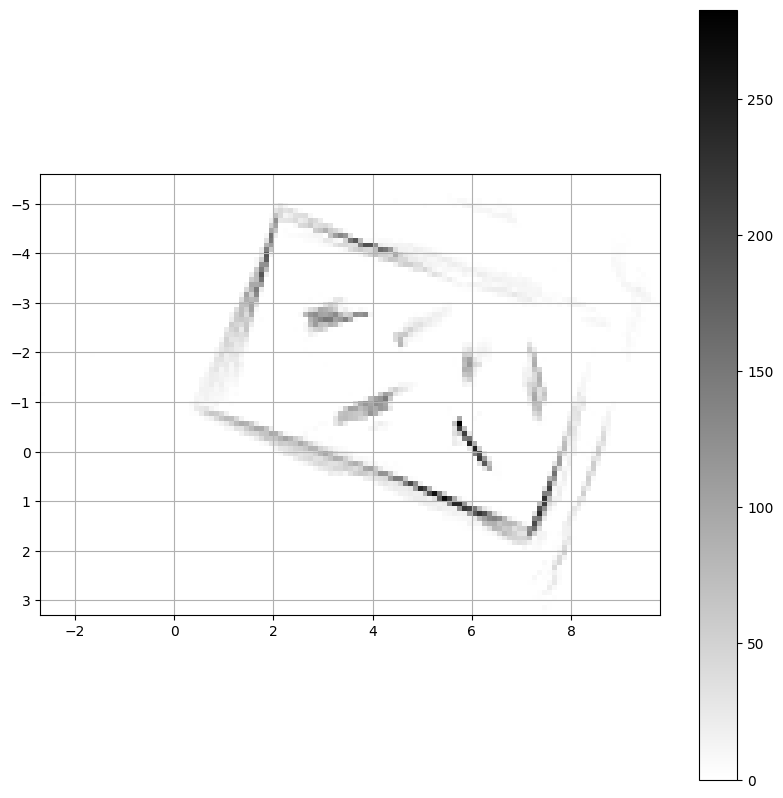

In [92]:
SCALE = 0.1

plt.figure(figsize=(10, 10))
with open("examples/examp7.txt") as file:
    for i, line in enumerate(file):
        c, d = line.split("; ")
        coords = np.array([float(number) for number in c.split(", ")])
        data = np.array([float(number) for number in d.split(", ")])
        if i == 0:
            a = new_measurement(coords, data, SCALE)
        else:
            a.update(new_measurement(coords, data, SCALE))
a.show()